In [1]:
import numpy as np
from math import sin, cos 

In [13]:
import numpy as np

def calcul_premier_second_membre_1_T(T, phi, j, dx, dy, dt, Prandt):
    Nx, Ny = T.shape
    premier_membre = np.zeros((Nx-2, Nx-2))
    second_membre = np.zeros(Nx-2)

    for i in range(1, Nx-1):
        premier_membre[i-1, i-1] = 1 + dt/(Prandt*dx*dx)

        second_membre[i-1] = (
            T[i, j] * (1 - dt/(Prandt*dy*dy))
            + T[i, j+1] * ( dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) + dt/(2*Prandt*dy*dy) )
            + T[i, j-1] * ( -dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) + dt/(2*Prandt*dy*dy) )
        )

        if 1 < i < Nx-2:
            premier_membre[i-1, i]   = dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)
            premier_membre[i-1, i-2] = -dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)
        elif i == 1:
            premier_membre[i-1, i]   = dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)
            premier_membre[i-1, i-1] += -dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)
        elif i == Nx-2:
            premier_membre[i-1, i-2] = -dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)
            premier_membre[i-1, i-1] += dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) - dt/(2*Prandt*dx*dx)

    return premier_membre, second_membre

def calcul_premier_second_membre_2_T(T, phi, i, dx, dy, dt, Prandt):
    Nx, Ny = T.shape
    premier_membre = np.zeros((Ny-2, Ny-2))
    second_membre = np.zeros(Ny-2)

    for j in range(1, Ny-1):
        premier_membre[j-1, j-1] = 1 + dt/(Prandt*dy*dy)

        second_membre[j-1] = (
            T[i, j] * (1 - dt/(Prandt*dx*dx))
            + T[i+1, j] * (-dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) + dt/(2*Prandt*dx*dx))
            + T[i-1, j] * ( dt/8*(phi[i, j+1] - phi[i, j-1])/(dx*dy) + dt/(2*Prandt*dx*dx))
        )

        if 1 < j < Ny-2:
            premier_membre[j-1, j]   = -dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) - dt/(2*Prandt*dy*dy)
            premier_membre[j-1, j-2] =  dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) - dt/(2*Prandt*dy*dy)
        elif j == 1:
            premier_membre[j-1, j]   = -dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) - dt/(2*Prandt*dy*dy)
            second_membre[j-1] -= ( dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) - dt/(2*Prandt*dy*dy) )
        elif j == Ny-2:
            premier_membre[j-1, j-2] = dt/8*(phi[i+1, j] - phi[i-1, j])/(dx*dy) - dt/(2*Prandt*dy*dy)
            # Termes aux limites connus → second_membre reste inchangé

    return premier_membre, second_membre

def algorithme_thomas(A, d):
    """
    Résout Ax = d pour une matrice tridiagonale A
    """
    n = A.shape[0]
    a = np.zeros(n-1)
    b = np.zeros(n)
    c = np.zeros(n-1)

    for i in range(n):
        b[i] = A[i, i]
        if i > 0:
            a[i-1] = A[i, i-1]
        if i < n-1:
            c[i] = A[i, i+1]

    # Forward elimination
    for i in range(1, n):
        m = a[i-1]/b[i-1]
        b[i] -= m*c[i-1]
        d[i] -= m*d[i-1]

    # Back substitution
    x = np.zeros(n)
    x[-1] = d[-1]/b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i]*x[i+1])/b[i]

    return x

def calcul_maille_temperature_n_plus_1(T, Prandt, dx, dy, dt, phi):
    Nx, Ny = T.shape
    T_n_plus_demi = np.zeros((Nx, Ny))
    T_n_plus_un   = np.zeros((Nx, Ny))

    # --------------------
    # Étape 1 : direction y (colonnes)
    # --------------------
    for j in range(1, Ny-1):
        A_j, b_j = calcul_premier_second_membre_1_T(T, phi, j, dx, dy, dt, Prandt)
        T_n_plus_demi[1:-1, j] = algorithme_thomas(A_j, b_j)

    # Conditions aux limites en x
    T_n_plus_demi[:, 0]  = 1    # bord gauche
    T_n_plus_demi[:, -1] = 0    # bord droit

    # Conditions aux limites en y (derivées nulles)
    T_n_plus_demi[0, 1:-1]  = T_n_plus_demi[1, 1:-1]
    T_n_plus_demi[-1, 1:-1] = T_n_plus_demi[-2, 1:-1]

    # --------------------
    # Étape 2 : direction x (lignes)
    # --------------------
    for i in range(1, Nx-1):
        A_i, b_i = calcul_premier_second_membre_2_T(T_n_plus_demi, phi, i, dx, dy, dt, Prandt)
        T_n_plus_un[i, 1:-1] = algorithme_thomas(A_i, b_i)

    # Conditions aux limites en y
    T_n_plus_un[:, 0]  = 1    # bord gauche
    T_n_plus_un[:, -1] = 0    # bord droit

    # Conditions aux limites en x (derivées nulles)
    T_n_plus_un[0, 1:-1]  = T_n_plus_un[1, 1:-1]
    T_n_plus_un[-1, 1:-1] = T_n_plus_un[-2, 1:-1]

    return T_n_plus_un


In [14]:
import numpy as np

# Paramètres
Nx, Ny = 5, 5
dx, dy = 1.0, 1.0
dt = 0.1
Prandt = 1.0

# Champ initial de température
T_init = np.zeros((Nx, Ny))

# Conditions aux limites initiales
T_init[:, 0] = 1.0  # bord gauche
T_init[:, -1] = 0.0 # bord droit

# Champ phi simple (pour tester la convection)
phi = np.zeros((Nx, Ny))
phi[2, 2] = 1.0  # petite perturbation au centre

# Calcul de T^{n+1} avec le schéma ADI
T_next = calcul_maille_temperature_n_plus_1(T_init, Prandt, dx, dy, dt, phi)

# Affichage
print("T initial :\n", T_init)
print("\nT à l'étape n+1 :\n", T_next)


T initial :
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

T à l'étape n+1 :
 [[1.00000000e+00 9.10505470e-02 3.11203320e-03 1.41456054e-04
  0.00000000e+00]
 [1.00000000e+00 9.10505470e-02 3.11203320e-03 1.41456054e-04
  0.00000000e+00]
 [1.00000000e+00 9.10976990e-02 4.14937759e-03 1.88608072e-04
  0.00000000e+00]
 [1.00000000e+00 9.11448510e-02 5.18672199e-03 2.35760091e-04
  0.00000000e+00]
 [1.00000000e+00 9.11448510e-02 5.18672199e-03 2.35760091e-04
  0.00000000e+00]]


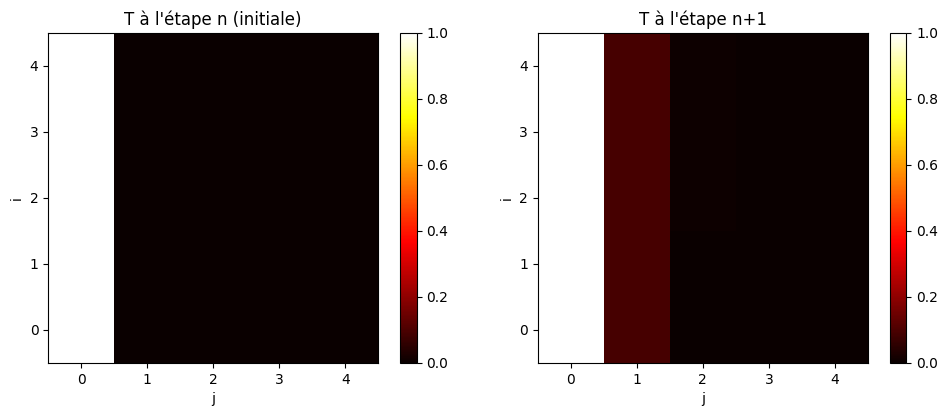

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# On suppose que T_init et T_next sont déjà définis
# (T_init : étape n, T_next : étape n+1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Affichage de T initial
im0 = axes[0].imshow(T_init, origin='lower', cmap='hot', interpolation='nearest')
axes[0].set_title("T à l'étape n (initiale)")
axes[0].set_xlabel("j")
axes[0].set_ylabel("i")
fig.colorbar(im0, ax=axes[0])

# Affichage de T après une étape ADI
im1 = axes[1].imshow(T_next, origin='lower', cmap='hot', interpolation='nearest')
axes[1].set_title("T à l'étape n+1")
axes[1].set_xlabel("j")
axes[1].set_ylabel("i")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()
